# Analysis of External Factors that Impact Sales of a Retail Store- A Regression Analysis

## Introduction

### In the highly competitive landscape of the retail industry, understanding the multifaceted dynamics that influence sales performance is essential for strategic decision-making. External factors, ranging from economic indicators and seasonal trends to marketing efforts and competitive influences, play a pivotal role in shaping a retail store's sales trajectory. Through a comprehensive regression analysis, this study aims to delve into the intricate relationships between these external variables and sales outcomes. By quantifying the impact of these factors, retailers can glean actionable insights to optimize operations, tailor marketing strategies, and ultimately enhance their revenue-generation potential.

## Problem statement

### The problem at hand pertains to comprehensively investigating the external factors that have a bearing on the sales performance of retail stores. While existing research acknowledges the significance of various factors such as economic indicators, seasonal trends, and marketing strategies, there remains a gap in terms of a comprehensive and up-to-date analysis that quantifies the individual and collective impacts of these factors. This study aims to bridge this gap by conducting a rigorous regression analysis, thus providing a more nuanced understanding of the interplay between external variables and sales outcomes. The ultimate goal is to offer retailers actionable insights that can drive informed decision-making, optimize resource allocation, and enhance overall sales effectiveness in a competitive retail environment.

## Objective

### The objective of this study is to investigate how external factors such as holiday events, oil prices, public sectors wages and natural occurences, impact the sales of Corporation Favorita, a large Ecuadorian-based grocery retailer.

## Hypothesis

### Null Hypothesis: Promotions have no significant effect on product sales.

### Alternate Hypothesis:  Promotions positively impact product sales, leading to increased sales during promotional periods.

## Questions

### The questions below are to be answered

### 1. Is the train dataset complete (has all the required dates)?

### 2. Which dates have the lowest and highest sales for each year?

### 3. Did the earthquake impact sales?

### 4. Are certain groups of stores selling more products? (Cluster, city, state, type)

### 5. Are sales affected by promotions, oil prices and holidays?

### 6. What analysis can we get from the date and its extractable features?

### 7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

## Other Questions

### The study seeks to answer the following key questions

### 1.	What is the effect of seasonal variations (e.g., Monthly, or quarterly patterns) on total sales?
### 2.	What store is the highest performer in terms of sales?
### 3.	What are the best-selling products per location?
### 4.	Does store size affect total sales?
### 5.	Which days have the most sales?

### By answering these questions Retailers, including Corporation Favorita can glean actionable insights to optimize operations, tailor marketing strategies, and ultimately enhance their revenue-generation potential.





In [2]:
# Installations
#%pip install python-dotenv
#%pip install pyodbc
#%pip install pandas
#%pip install numpy

In [3]:

#these are the libraries that will be used for the analysis
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from sklearn.impute import SimpleImputer

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# credentials for data extraction from Microsoft server

environment_variables=dotenv_values('.env')

database=environment_variables.get("database")
server=environment_variables.get("server")
username=environment_variables.get("username")
password=environment_variables.get("password")

connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

connection=pyodbc.connect(connection_string)

In [5]:
# extract data from Table 1: dbo.oil
# assign it to data1
# preview data1

query="Select * from dbo.oil" 
data1=pd.read_sql(query, connection)

data1.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [6]:
# Save extracted data as data1.csv
file_path = "C:/Users/user/Desktop/AZUBI-LP3/Regression-Model/Datasets/oil.csv"
data1.to_csv(file_path,  index=False)

In [7]:
# read the oil dataset
oil = pd.read_csv(r"C:/Users/user/Desktop/LP3/Store-Sales-Forecasting/Datasets/oil.csv", parse_dates=["date"])
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [8]:
# check for missing values
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [9]:
# rename column 'dcoilwtico' to oil_price in oil.csv

oil.rename(columns={'dcoilwtico':'oil_prices'}, inplace=True)
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   oil_prices  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [10]:
# extract data from Table 2: dbo.holidays_events
# assign it to data2
# preview data2

query2="Select * from dbo.holidays_events" 
data2=pd.read_sql(query2, connection)

data2.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [11]:
# Save extracted data as data2.csv
# Define the file path to save the CSV file on your desktop
file_path = "C:/Users/user/Desktop/AZUBI-LP3/Regression-Model/Datasets/holidays_events.csv"
data2.to_csv(file_path,  index=False)

In [12]:
# read the holiday dataset
holiday = pd.read_csv(r"C:/Users/user/Desktop/LP3/Store-Sales-Forecasting/Datasets/holidays_events.csv", parse_dates=["date"])
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [13]:
# check for mising values
holiday.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [14]:
# extract data from Table 3: dbo.stores
# assign it to data3
# preview data3

query3="Select * from dbo.stores" 
data3=pd.read_sql(query3, connection)

data3.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [15]:
# Save extracted data as data3.csv
file_path = "C:/Users/user/Desktop/AZUBI-LP3/Regression-Model/Datasets/stores.csv"
data3.to_csv(file_path,  index=False)

In [16]:
# read the stores dataset
stores = pd.read_csv(r"C:/Users/user/Desktop/LP3/Store-Sales-Forecasting/Datasets/stores.csv")

In [17]:
# read the test dataset and convert the date column to datetime
test = pd.read_csv(r"C:/Users/user/Downloads/onedrive/onedrive/test.csv", parse_dates=["date"])
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [19]:
# check for null values
test.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [20]:
# read the train dataset and convert the date column to datetime
train = pd.read_csv(r"C:/Users/user/Downloads/from github/from github/train.csv", parse_dates=["date"])
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [22]:
# check for null values
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [23]:
# read the transaction dataset and convert the date column to datetime
transactions = pd.read_csv(r"C:/Users/user/Downloads/from github/from github/transactions.csv", parse_dates=["date"])
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [24]:
# check for null values
transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

### all datasets have non-null values except for oil dataset that has 43 null values.

## Exploratory Data Analysis
### Here we examine the datasets in depth to gain insights, understand patterns, and identify anomalies within the time-ordered datasets.

### checking ranges of dates

In [25]:
# check range of dates for oil.csv

oil['date'].min(), oil['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-31 00:00:00'))

In [26]:
# check range of dates for holidays_events.csv
holiday['date'].min(), holiday['date'].max()

(Timestamp('2012-03-02 00:00:00'), Timestamp('2017-12-26 00:00:00'))

In [27]:
# check range of dates for transactions.csv
transactions['date'].min(), transactions['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [28]:
# check range of dates for test.csv

test['date'].min(), test['date'].max()

(Timestamp('2017-08-16 00:00:00'), Timestamp('2017-08-31 00:00:00'))

In [29]:
# check range of dates for train.csv

train['date'].min(), train['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

### From the date ranges the range of the test dataset is 15 days after the train dataset. however, we can see that the transaction dataset ranges within the train range.

## Bivariate Analysis

## Train Dataset Analysis

### 1. Is the train dataset complete (has all the required dates)?

In [31]:
# check range of dates for train.csv
train['date'].min(),train['date'].max()


(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [32]:
# Define a date range that should be complete
start_date = pd.to_datetime("2013-01-01")
end_date = pd.to_datetime("2017-08-15")

# Create a reference date range
reference_dates = pd.date_range(start=start_date, end=end_date, freq="D")

# Find missing dates in the train dataset
missing_dates = reference_dates[~reference_dates.isin(train["date"])]

if len(missing_dates) == 0:
    print("The train dataset is complete.")
else:
    print("Missing dates in the train dataset:", missing_dates)



Missing dates in the train dataset: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


### The train data is missing four dates, which is 25th December of 2013,2014,2015 and 2016.

### Which dates have the lowest and highest sales for each year?

In [33]:
# Group the data by year and find the date with the lowest sales
lowest_sales_date = train.loc[train.groupby(train['date'].dt.year)['sales'].idxmin()]

# Group the data by year and find the date with the highest sales
highest_sales_date = train.loc[train.groupby(train['date'].dt.year)['sales'].idxmax()]

# Display results
print("Dates with lowest sales in each year:")
print(lowest_sales_date[['date','sales']])

print("Dates with highest sales in each year:")
print(highest_sales_date[['date','sales']])

Dates with lowest sales in each year:
              date  sales
0       2013-01-01    0.0
648648  2014-01-01    0.0
1297296 2015-01-01    0.0
1945944 2016-01-01    0.0
2596374 2017-01-01    0.0
Dates with highest sales in each year:
              date       sales
562596  2013-11-12   46271.000
1257246 2014-12-08   45361.000
1916586 2015-12-14   40351.460
2163723 2016-05-02  124717.000
2760297 2017-04-02   38422.625


### From the results we can conclude that the grocery store does not open on the 1st day of each year as evidenced by zero sales. The store also received the highest sales in 2016-05-02, which is about a week after 16 April 2016, 23:58 UTC when a powerful earthquake (7.8 M) struck the coast of Ecuador. 

### Did the earthquake impact sales?

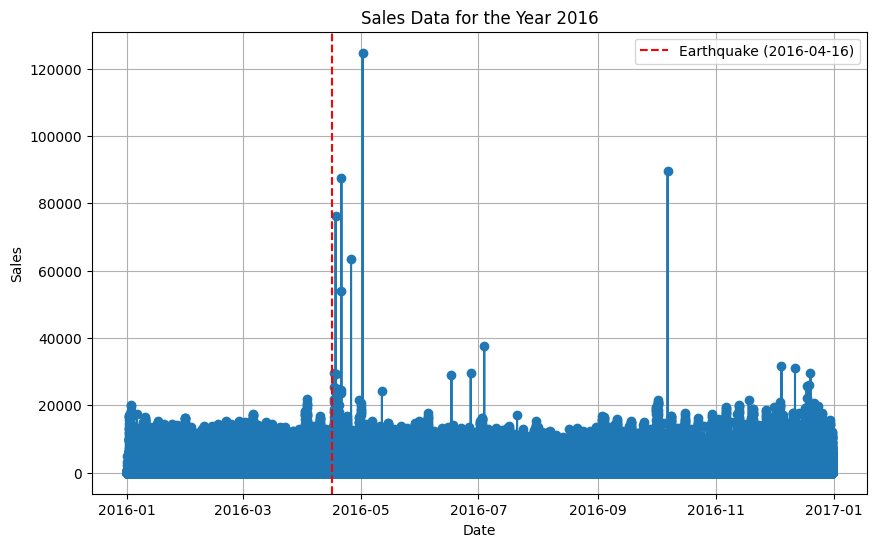

In [34]:
# Filter data for the year 2016
sales_2016 = train[train["date"].dt.year == 2016]

# Plotting the sales data for 2016 using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(sales_2016["date"], sales_2016["sales"], marker='o')
plt.axvline(pd.to_datetime("2016-04-16"), color='r', linestyle='--', label="Earthquake (2016-04-16)")
plt.title("Sales Data for the Year 2016")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()

### From the visualization, the earthquake had a significant impact on sales. The high sales could be a response of the damage caused by the earthquake as people seek to get more supplies to ensure they are ready for any potential disruptions and also concerns about the availability of goods as earthquakes can disrupt supply chains and transportation networks.

### Are sales affected by promotions?

In [36]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


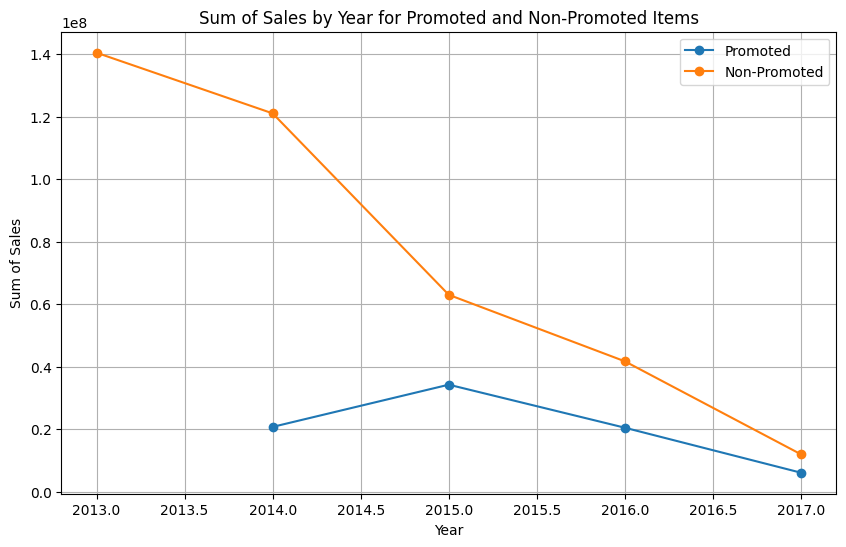

In [41]:
# Filter data for promoted and non-promoted items
promoted_items = train[train['onpromotion'] == 1]
non_promoted_items = train[train['onpromotion'] == 0]

# Group data by year and onpromotion, and calculate the sum of sales
promoted_sales_by_year = promoted_items.groupby([promoted_items["date"].dt.year, "onpromotion"])["sales"].sum().reset_index()
non_promoted_sales_by_year = non_promoted_items.groupby([non_promoted_items["date"].dt.year, "onpromotion"])["sales"].sum().reset_index()

# Plotting the sum of sales for promoted and non-promoted items by year using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(promoted_sales_by_year[promoted_sales_by_year["onpromotion"] == 1]["date"],
         promoted_sales_by_year[promoted_sales_by_year["onpromotion"] == 1]["sales"],
         marker='o', label="Promoted")
plt.plot(non_promoted_sales_by_year[non_promoted_sales_by_year["onpromotion"] == 0]["date"],
         non_promoted_sales_by_year[non_promoted_sales_by_year["onpromotion"] == 0]["sales"],
         marker='o', label="Non-Promoted")
plt.title("Sum of Sales by Year for Promoted and Non-Promoted Items")
plt.xlabel("Year")
plt.ylabel("Sum of Sales")
plt.grid(True)
plt.legend()
plt.show()


### The visualization above shows that the grocery store make more sales for items not on promotion compared to items on promotion. however, to have a clear picture on whether promotion affect sales, we need to filter the analysis to specific items.

## Stores dataset analysis

### Are certain groups of stores selling more products? (Cluster, city, state, type)

In [35]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
